# Variational Fourier Features in the GPflow framework

In this notebook we demonstrate how new types of inducing variables can easily be incorporated in the GPflow framework. As an example case, we use the variational Fourier features from [Hensman, Durrande, and Solin (JMLR 2018)](http://jmlr.csail.mit.edu/papers/v18/16-579). All equation and table references are to this paper.

**Note:** This implementation is meant as an example, not as a feature-complete implementation. For more features, such as multi-dimensional inputs, use the [GPflow 2 version of the original VFF code](https://github.com/st--/VFF).

We cannot directly use Fourier features within the multi-output framework without losing the computational advantages, as `Kuu` and `Kuf` for SharedIndependent and SeparateIndependent inducing variables assume that the sub-inducing variable's covariances are simply computed as dense Tensors. However, there is nothing preventing a dedicated implementation of multi-output Fourier features that is computationally more efficient - feel free to discuss this within [the GPflow community](https://github.com/GPflow/GPflow/#the-gpflow-community)!

In [1]:
import tensorflow as tf
import numpy as np
import gpflow
from gpflow.inducing_variables import InducingVariables
from gpflow.base import TensorLike
from gpflow.utilities import to_default_float
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from gpflow.ci_utils import ci_niter

In [2]:
# VFF give structured covariance matrices that are computationally efficient.
# We take advantage of this using TensorFlow's LinearOperators:
BlockDiag = tf.linalg.LinearOperatorBlockDiag
Diag = tf.linalg.LinearOperatorDiag
LowRank = tf.linalg.LinearOperatorLowRankUpdate

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

The VFF inducing variables are defined as a projection $u_m = \mathcal{P}_{\phi_m}(f)$ (eq. (59)) of the GP $f(\cdot)$ onto a truncated Fourier basis, $\phi_m = [1, \cos(\omega_1(x-a)),\dots,\cos(\omega_M(x-a)),\sin(\omega_1(x-a)),\dots,\sin(\omega_M(x-a))]$ (eq. (47)). To represent this we define a new inducing variables class that derives from the `InducingVariables` base class.

In [4]:
class FourierFeatures1D(InducingVariables):
    def __init__(self, a, b, M):
        """
        `a` and `b` define the interval [a, b] of the Fourier representation.
        `M` specifies the number of frequencies to use.
        """
        # [a, b] defining the interval of the Fourier representation:
        self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
        self.b = gpflow.Parameter(b, dtype=gpflow.default_float())
        # integer array defining the frequencies, ω_m = 2π (b - a)/m:
        self.ms = np.arange(M)

    @property
    def num_inducing(self):
        """ number of inducing variables (defines dimensionality of q(u)) """
        return 2 * tf.shape(self.ms)[0] - 1  # `M` cosine and `M-1` sine components

Next, we need to define how to compute $\mathrm{K}_\mathbf{uu} = \operatorname{cov}(u_m, u_{m'})$ (eq. (61)) and $\mathrm{K}_\mathbf{uf} = \operatorname{cov}(u_m, f(x_n))$ (eq. (60)).

In [5]:
@cov.Kuu.register(FourierFeatures1D, gpflow.kernels.Matern12)
def Kuu_matern12_fourierfeatures1d(inducing_variable, kernel, jitter=None):
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2.0 * np.pi * ms / (b - a)

    # Cosine block:
    lamb = 1.0 / kernel.lengthscales
    two_or_four = to_default_float(tf.where(omegas == 0, 2.0, 4.0))
    d_cos = (
        (b - a) * (tf.square(lamb) + tf.square(omegas)) / lamb / kernel.variance / two_or_four
    )  # eq. (111)
    v_cos = tf.ones_like(d_cos) / tf.sqrt(kernel.variance)  # eq. (110)
    cosine_block = LowRank(Diag(d_cos, is_positive_definite=True), v_cos[:, None])

    # Sine block:
    omegas = omegas[tf.not_equal(omegas, 0)]  # the sine block does not include omega=0
    d_sin = (
        (b - a) * (tf.square(lamb) + tf.square(omegas)) / lamb / kernel.variance / 4.0
    )  # eq. (113)
    sine_block = Diag(d_sin, is_positive_definite=True)

    return BlockDiag([cosine_block, sine_block])


@cov.Kuf.register(FourierFeatures1D, gpflow.kernels.Matern12, TensorLike)
def Kuf_matern12_fourierfeatures1d(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)

    omegas = 2.0 * np.pi * ms / (b - a)
    Kuf_cos = tf.cos(omegas[:, None] * (X[None, :] - a))
    omegas_sin = omegas[tf.not_equal(omegas, 0)]  # don't compute zero frequency
    Kuf_sin = tf.sin(omegas_sin[:, None] * (X[None, :] - a))

    # correct Kuf outside [a, b] -- see Table 1
    Kuf_sin = tf.where((X < a) | (X > b), tf.zeros_like(Kuf_sin), Kuf_sin)  # just zero

    left_tail = tf.exp(-tf.abs(X - a) / kernel.lengthscales)[None, :]
    right_tail = tf.exp(-tf.abs(X - b) / kernel.lengthscales)[None, :]
    Kuf_cos = tf.where(X < a, left_tail, Kuf_cos)  # replace with left tail
    Kuf_cos = tf.where(X > b, right_tail, Kuf_cos)  # replace with right tail

    return tf.concat([Kuf_cos, Kuf_sin], axis=0)


@cov.Kuu.register(FourierFeatures1D, gpflow.kernels.Matern32)
def Kuu_matern32_fourierfeatures1d(inducing_variable, kernel, jitter=None):
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2.0 * np.pi * ms / (b - a)

    # Cosine block: eq. (114)
    lamb = np.sqrt(3.0) / kernel.lengthscales
    four_or_eight = to_default_float(tf.where(omegas == 0, 4.0, 8.0))
    d_cos = (
        (b - a)
        * tf.square(tf.square(lamb) + tf.square(omegas))
        / tf.pow(lamb, 3)
        / kernel.variance
        / four_or_eight
    )
    v_cos = tf.ones_like(d_cos) / tf.sqrt(kernel.variance)
    cosine_block = LowRank(Diag(d_cos, is_positive_definite=True), v_cos[:, None])

    # Sine block: eq. (115)
    omegas = omegas[tf.not_equal(omegas, 0)]  # don't compute omega=0
    d_sin = (
        (b - a)
        * tf.square(tf.square(lamb) + tf.square(omegas))
        / tf.pow(lamb, 3)
        / kernel.variance
        / 8.0
    )
    v_sin = omegas / lamb / tf.sqrt(kernel.variance)
    sine_block = LowRank(Diag(d_sin, is_positive_definite=True), v_sin[:, None])

    return BlockDiag([cosine_block, sine_block])  # eq. (116)


@cov.Kuf.register(FourierFeatures1D, gpflow.kernels.Matern32, TensorLike)
def Kuf_matern32_fourierfeatures1d(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2.0 * np.pi * ms / (b - a)

    Kuf_cos = tf.cos(omegas[:, None] * (X[None, :] - a))
    omegas_sin = omegas[tf.not_equal(omegas, 0)]  # don't compute zeros freq.
    Kuf_sin = tf.sin(omegas_sin[:, None] * (X[None, :] - a))

    # correct Kuf outside [a, b] -- see Table 1

    def tail_cos(delta_X):
        arg = np.sqrt(3) * tf.abs(delta_X) / kernel.lengthscales
        return (1 + arg) * tf.exp(-arg)[None, :]

    Kuf_cos = tf.where(X < a, tail_cos(X - a), Kuf_cos)
    Kuf_cos = tf.where(X > b, tail_cos(X - b), Kuf_cos)

    def tail_sin(delta_X):
        arg = np.sqrt(3) * tf.abs(delta_X) / kernel.lengthscales
        return delta_X[None, :] * tf.exp(-arg) * omegas_sin[:, None]

    Kuf_sin = tf.where(X < a, tail_sin(X - a), Kuf_sin)
    Kuf_sin = tf.where(X > b, tail_sin(X - b), Kuf_sin)

    return tf.concat([Kuf_cos, Kuf_sin], axis=0)

In principle, this is all we need; however, to be able to take advantage of the structure of `Kuu`, we need to also implement new versions of the KL divergence from the prior to the approximate posterior (`prior_kl`) and the computation of the Gaussian process conditional (posterior) equations:

In [6]:
@kl.prior_kl.register(FourierFeatures1D, gpflow.kernels.Kernel, TensorLike, TensorLike)
def prior_kl_vff(inducing_variable, kernel, q_mu, q_sqrt, whiten=False):
    if whiten:
        raise NotImplementedError
    K = cov.Kuu(inducing_variable, kernel)
    return gauss_kl_vff(q_mu, q_sqrt, K)


def gauss_kl_vff(q_mu, q_sqrt, K):
    """
    Compute the KL divergence from

          q(x) = N(q_mu, q_sqrt^2)
    to
          p(x) = N(0, K)

    q_mu is a vector [N, 1] that contains the mean.
    q_sqrt is a matrix that is the lower triangular square-root matrix of the covariance of q.

    K is a positive definite matrix: the covariance of p.
    NOTE: K is a LinearOperator that provides efficient methjods
        for solve(), log_abs_determinant(), and trace()
    """
    # KL(N₀ || N₁) = ½ [tr(Σ₁⁻¹ Σ₀) + (μ₁ - μ₀)ᵀ Σ₁⁻¹ (μ₁ - μ₀) - k + ln(det(Σ₁)/det(Σ₀))]
    # N₀ = q; μ₀ = q_mu, Σ₀ = q_sqrt q_sqrtᵀ
    # N₁ = p; μ₁ = 0, Σ₁ = K
    # KL(q || p) =
    #     ½ [tr(K⁻¹ q_sqrt q_sqrtᵀA + q_muᵀ K⁻¹ q_mu - k + logdet(K) - logdet(q_sqrt q_sqrtᵀ)]
    # k = number of dimensions, if q_sqrt is m x m this is m²
    Kinv_q_mu = K.solve(q_mu)

    mahalanobis_term = tf.squeeze(tf.matmul(q_mu, Kinv_q_mu, transpose_a=True))

    # GPflow: q_sqrt is num_latent_gps x N x N
    num_latent_gps = to_default_float(tf.shape(q_mu)[1])
    logdet_prior = num_latent_gps * K.log_abs_determinant()

    product_of_dimensions__int = tf.reduce_prod(tf.shape(q_sqrt)[:-1])  # dimensions are integers
    constant_term = to_default_float(product_of_dimensions__int)

    Lq = tf.linalg.band_part(q_sqrt, -1, 0)  # force lower triangle
    logdet_q = tf.reduce_sum(tf.math.log(tf.square(tf.linalg.diag_part(Lq))))

    # S = tf.matmul(q_sqrt, q_sqrt, transpose_b=True)
    # trace_term = tf.trace(K.solve(S))
    trace_term = tf.squeeze(
        tf.reduce_sum(Lq * K.solve(Lq), axis=[-1, -2])
    )  # [O(N²) instead of O(N³)

    twoKL = trace_term + mahalanobis_term - constant_term + logdet_prior - logdet_q
    return 0.5 * twoKL

In [7]:
import gpflow.posteriors


class VFFPosterior(gpflow.posteriors.BasePosterior):
    def _conditional_fused(self, Xnew, full_cov, full_output_cov):
        """
        Xnew is a tensor with the points of the data or minibatch, shape N x D
        """
        if full_output_cov:
            raise NotImplementedError

        f = self._q_dist.q_mu
        q_sqrt = self._q_dist.q_sqrt

        # num_data = tf.shape(Xnew)[0]  # M
        num_func = tf.shape(f)[1]  # K

        Kuu = cov.Kuu(self.X_data, self.kernel)  # this is now a LinearOperator
        Kuf = cov.Kuf(self.X_data, self.kernel, Xnew)  # still a Tensor

        KuuInv_Kuf = Kuu.solve(Kuf)

        # compute the covariance due to the conditioning
        if full_cov:
            fvar = self.kernel(Xnew) - tf.matmul(Kuf, KuuInv_Kuf, transpose_a=True)
            shape = (num_func, 1, 1)
        else:
            KufT_KuuInv_Kuf_diag = tf.reduce_sum(Kuf * KuuInv_Kuf, axis=-2)
            fvar = self.kernel(Xnew, full_cov=False) - KufT_KuuInv_Kuf_diag
            shape = (num_func, 1)
        fvar = tf.expand_dims(fvar, 0) * tf.ones(
            shape, dtype=gpflow.default_float()
        )  # K x N x N or K x N

        if self.whiten:
            raise NotImplementedError

        A = KuuInv_Kuf

        # construct the conditional mean
        fmean = tf.matmul(A, f, transpose_a=True)

        if q_sqrt is not None:
            if q_sqrt.get_shape().ndims == 2:
                # LTA = A * tf.expand_dims(q_sqrt, 2)  # K x M x N
                # won't work  # make ticket for this?
                raise NotImplementedError
            elif q_sqrt.get_shape().ndims == 3:
                # L = tf.matrix_band_part(tf.transpose(q_sqrt, (2, 0, 1)), -1, 0)  # K x M x M

                # K x M x N
                # A_tiled = tf.expand_dims(A.get(), 0) * tf.ones((num_func, 1, 1), dtype=float_type)

                # LTA = tf.matmul(L, A_tiled, transpose_a=True)  # K x M x N
                # TODO the following won't work for K > 1
                assert q_sqrt.shape[0] == 1
                # LTA = (A.T @ DenseMatrix(q_sqrt[:,:,0])).T.get()[None, :, :]
                ATL = tf.matmul(A, q_sqrt, transpose_a=True)
            else:
                raise ValueError("Bad dimension for q_sqrt: %s" % str(q_sqrt.get_shape().ndims))
            if full_cov:
                # fvar = fvar + tf.matmul(LTA, LTA, transpose_a=True)  # K x N x N
                fvar = fvar + tf.matmul(ATL, ATL, transpose_b=True)  # K x N x N
            else:
                # fvar = fvar + tf.reduce_sum(tf.square(LTA), 1)  # K x N
                fvar = fvar + tf.reduce_sum(tf.square(ATL), 2)  # K x N
        fvar = tf.transpose(fvar)  # N x K or N x N x K

        return fmean, fvar

    # We can also provide a conditional that precomputes as much as possible,
    # to speed up predictions:

    def _precompute(self):
        Kuu = cov.Kuu(self.X_data, self.kernel)  # this is now a LinearOperator

        q_mu = self._q_dist.q_mu
        q_sqrt = self._q_dist.q_sqrt

        if self.whiten:
            raise NotImplementedError
        else:
            # alpha = Kuu⁻¹ q_mu
            alpha = Kuu.solve(q_mu)  # type: tf.Tensor

        if self.whiten:
            raise NotImplementedError
        else:
            # Qinv = Kuu⁻¹ - Kuu⁻¹ S Kuu⁻¹
            KuuInv_qsqrt = Kuu.solve(q_sqrt)
            KuuInv_covu_KuuInv = tf.matmul(KuuInv_qsqrt, KuuInv_qsqrt, transpose_b=True)

        Qinv = Kuu.inverse().to_dense() - KuuInv_covu_KuuInv

        return alpha, Qinv

    def _conditional_with_precompute(self, cache, Xnew, full_cov, full_output_cov):
        alpha, Qinv = cache

        if full_output_cov:
            raise NotImplementedError

        Kuf = cov.Kuf(self.X_data, self.kernel, Xnew)  # still a Tensor

        # construct the conditional mean
        fmean = tf.matmul(Kuf, alpha, transpose_a=True)

        num_func = tf.shape(alpha)[1]  # K
        Qinv_Kuf = tf.matmul(Qinv, Kuf)

        # compute the covariance due to the conditioning
        if full_cov:
            fvar = self.kernel(Xnew) - tf.matmul(Kuf, Qinv_Kuf, transpose_a=True)
        else:
            KufT_Qinv_Kuf_diag = tf.reduce_sum(Kuf * Qinv_Kuf, axis=-2)
            fvar = self.kernel(Xnew, full_cov=False) - KufT_Qinv_Kuf_diag
        fvar = tf.transpose(fvar)

        return fmean, fvar

We now have to register our Posterior object:

In [8]:
@gpflow.posteriors.get_posterior_class.register(gpflow.kernels.Kernel, FourierFeatures1D)
def _get_posterior_vff(kernel, inducing_variable):
    return VFFPosterior

`gpflow.conditionals.conditional` is a short-hand for calling the fused prediction code path:

In [9]:
Mf = 2
M = 2 * Mf - 1
kernel = gpflow.kernels.Matern32()
inducing_variable = FourierFeatures1D(-0.5, 1.5, Mf)

Xnew = np.random.rand(7, 1)
f = np.random.randn(M, 1)
q_sqrt = tf.convert_to_tensor(np.tril(np.random.randn(1, M, M)))

conditional_f_mean, conditional_f_var = gpflow.conditionals.conditional(
    Xnew, inducing_variable, kernel, f, q_sqrt=q_sqrt, white=False, full_cov=True
)

posterior = VFFPosterior(kernel, inducing_variable, f, q_sqrt, whiten=False, precompute_cache=None)
posterior_f_mean, posterior_f_var = posterior.fused_predict_f(Xnew, full_cov=True)

np.testing.assert_array_equal(conditional_f_mean, posterior_f_mean)
np.testing.assert_array_equal(conditional_f_var, posterior_f_var)

Instructions for updating:
Do not call `graph_parents`.


We can also call the cached path:


In [10]:
posterior.update_cache(gpflow.posteriors.PrecomputeCacheType.TENSOR)
precomputed_posterior_f_mean, precomputed_posterior_f_var = posterior.predict_f(Xnew, full_cov=True)

np.testing.assert_allclose(precomputed_posterior_f_mean, posterior_f_mean)
np.testing.assert_allclose(precomputed_posterior_f_var, posterior_f_var)

We now demonstrate how to use these new types of inducing variables with the `SVGP` model class. First, let's create some toy data:

In [11]:
X = np.linspace(-2, 2, 510)
Xnew = np.linspace(-4, 4, 501)


def f(x):
    return np.cos(2 * np.pi * x / 4 * 2)


F = f(X)
Fnew = f(Xnew)
noise_scale = 0.1
np.random.seed(1)
Y = F + np.random.randn(*F.shape) * noise_scale

data = (X.reshape(-1, 1), Y.reshape(-1, 1))

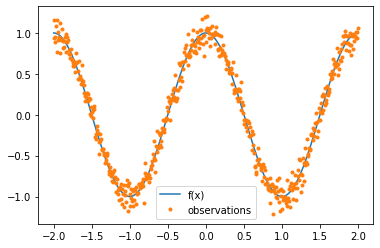

In [12]:
plt.figure()
plt.plot(X, F, label="f(x)")
plt.plot(X, Y, ".", label="observations")
plt.legend()
plt.show()

Setting up an SVGP model with variational Fourier feature inducing variables is as simple as replacing the `inducing_variable` argument:

In [13]:
Mfreq = 9
m = gpflow.models.SVGP(
    kernel=gpflow.kernels.Matern32(),
    likelihood=gpflow.likelihoods.Gaussian(variance=noise_scale ** 2),
    inducing_variable=FourierFeatures1D(-4.5, 4.5, Mfreq),
    num_data=len(X),
    whiten=False,
)
gpflow.set_trainable(m.kernel, False)
gpflow.set_trainable(m.likelihood, False)
gpflow.set_trainable(m.inducing_variable, True)  # whether to optimize bounds [a, b]

In [14]:
opt = gpflow.optimizers.Scipy()
opt.minimize(
    m.training_loss_closure(data),
    m.trainable_variables,
    options=dict(maxiter=ci_niter(5000)),
)

gpflow.utilities.print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,False,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,False,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.009999999999999998
SVGP.inducing_variable.a,Parameter,Identity,,True,(),float64,-4.1837954394991534
SVGP.inducing_variable.b,Parameter,Identity,,True,(),float64,4.184191774260224
SVGP.q_mu,Parameter,Identity,,True,"(17, 1)",float64,[[0.8939161...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 17, 17)",float64,"[[[1.35751663e+00, 0.00000000e+00, 0.00000000e+00..."


For comparison we also construct an SVGP model using inducing points and an exact GPR model:

In [15]:
m_ip = gpflow.models.SVGP(
    kernel=gpflow.kernels.Matern32(),
    likelihood=gpflow.likelihoods.Gaussian(variance=noise_scale ** 2),
    inducing_variable=np.linspace(-2, 2, Mfreq * 2 - 1)[:, None],
    num_data=len(X),
    whiten=False,
)
gpflow.set_trainable(m_ip.kernel, False)
gpflow.set_trainable(m_ip.likelihood, False)
gpflow.set_trainable(m_ip.inducing_variable, True)  # whether to optimize inducing point locations

In [16]:
opt = gpflow.optimizers.Scipy()
opt.minimize(
    m_ip.training_loss_closure(data),
    m_ip.trainable_variables,
    options=dict(maxiter=ci_niter(5000)),
)

gpflow.utilities.print_summary(m_ip, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,False,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,False,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.009999999999999998
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(17, 1)",float64,[[-1.93001699...
SVGP.q_mu,Parameter,Identity,,True,"(17, 1)",float64,[[0.9612163...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 17, 17)",float64,"[[[2.16516529e-02, 0.00000000e+00, 0.00000000e+00..."


In [17]:
m_ref = gpflow.models.GPR((X.reshape(-1, 1), Y.reshape(-1, 1)), kernel=gpflow.kernels.Matern32())
m_ref.likelihood.variance = np.array(noise_scale ** 2).astype(np.float64)
gpflow.set_trainable(m_ref.kernel, False)
gpflow.set_trainable(m_ref.likelihood, False)

# Because we fixed the kernel and likelihood hyperparameters, we don't need to optimize anything.

gpflow.utilities.print_summary(m_ref, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,False,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,False,(),float64,1


In [18]:
exact_gpr_lml = m_ref.log_marginal_likelihood().numpy().item()
print("LML (exact GPR) =", exact_gpr_lml)
ip_svgp_elbo = m_ip.elbo(data).numpy().item()
print("ELBO (SVGP, inducing points) =", ip_svgp_elbo)
vff_svgp_elbo = m.elbo(data).numpy().item()
print("ELBO (SVGP, Fourier features) =", vff_svgp_elbo)

LML (exact GPR) = 402.2158074486281
ELBO (SVGP, inducing points) = 365.3121608356282
ELBO (SVGP, Fourier features) = 171.03955056306515


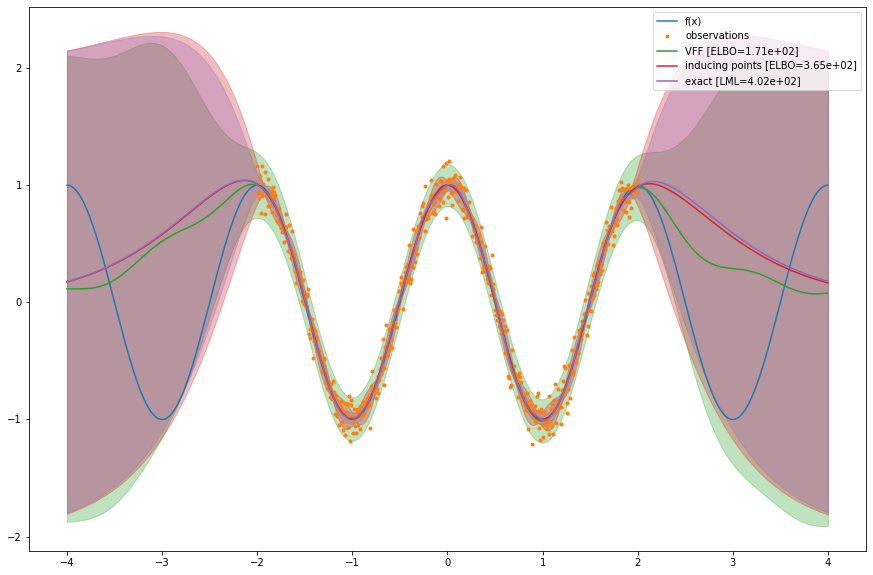

In [19]:
def plot_gp(m, Xnew, name=""):
    Fmean, Fvar = m.predict_f(Xnew[:, None])
    Fmean = Fmean.numpy().squeeze()
    Fvar = Fvar.numpy().squeeze()
    (p,) = plt.plot(Xnew, Fmean, label=name)
    plt.fill_between(
        Xnew, Fmean - 2 * np.sqrt(Fvar), Fmean + 2 * np.sqrt(Fvar), alpha=0.3, color=p.get_color()
    )


def plot_data():
    plt.plot(Xnew, Fnew, label="f(x)")
    plt.plot(X, Y, ".", label="observations")


plt.figure(figsize=(15, 10))
plot_data()
plot_gp(m, Xnew, "VFF [ELBO={:.3}]".format(vff_svgp_elbo))
plot_gp(m_ip, Xnew, "inducing points [ELBO={:.3}]".format(ip_svgp_elbo))
plot_gp(m_ref, Xnew, "exact [LML={:.3}]".format(exact_gpr_lml))
plt.legend(loc="best")
plt.show()